In [139]:
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import sys
sys.path.append('..')
# from config import INPUT_SIZE


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.transform = transform
        self.data_root = data_root
       # print(self.data_root)
        f = open(self.data_root + data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.labels = []

        for data in data_list:
            image_path = data[:-1]
            label = image_path.split('/')[1]
            self.img_paths.append(image_path)
            self.labels.append(label)

        print(len(set(self.labels)))

        self.label_dict = {}
        for i, label in enumerate(list(set(self.labels))):
            self.label_dict[label] = i

        print(self.label_dict)

    def __getitem__(self, item):

     #   print(self.data_root)
        img_path, label= self.img_paths[item], self.labels[item]
        #img_path_full = os.path.join(self.data_root, img_path)
        img_path_full = self.data_root+img_path
      #  print(img_path_full)
        img = Image.open(img_path_full).convert('RGB')
        # label = np.array(label,dtype='float32')
        label = self.label_dict[label]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return self.n_data

In [108]:
total_trainset = GetLoader(data_root='/userdata/smetzger/data/logos/train_and_test/train/',
        data_list='train_images_root.txt',
        transform=None)

2341
{'Scholler': 0, 'Oreo': 1, 'Mist': 2, 'McCafe': 3, 'Frosted Toast Crunch': 4, 'KP Nuts': 5, "Smith's Crisps": 6, 'Nine West': 7, 'Butterfinger Bites': 8, 'Kix': 9, 'Top': 10, 'H. J. Heinz': 11, 'Akubra': 12, 'Marmara': 13, 'Standard': 14, 'Karma': 15, 'Tropicana': 16, 'Gateway': 17, 'La Vie': 18, "Reese's Puffs": 19, 'Calvin Klein': 20, 'PG Tips': 21, 'Cathay': 22, 'Vittel': 23, 'Amora': 24, 'Pertamina': 25, 'Texas Roadhouse': 26, 'Rima': 27, 'Kent': 28, 'Neutral': 29, 'saky': 30, 'Campbells': 31, 'J. Lancaster & Son': 32, 'The Real Deal': 33, 'DC Shoes': 34, 'Elf': 35, 'Buffalo Rock Ginger Ale': 36, 'Mr Greedy': 37, 'Senator': 38, 'Choice Hotels': 39, 'Breath Savers': 40, 'Domus': 41, 'Bassett': 42, 'Liga': 43, 'Julmust': 44, 'Vimto': 45, 'SUNING': 46, 'Molson Canadian 67': 47, 'Organic Wild Puffs': 48, 'Schweppes Tonic': 49, 'Kern': 50, "Newman's Own": 51, 'Life is good': 52, 'Supra': 53, 'Crown': 54, 'Persil': 55, 'Los Angeles': 56, 'Coco Pops': 57, 'Albertsons': 58, 'Leed': 59

In [109]:
total_testset = GetLoader(data_root='/userdata/smetzger/data/logos/train_and_test/test/',
        data_list='test_images_root.txt',
        transform=None)

2341
{'Scholler': 0, 'Oreo': 1, 'Mist': 2, 'McCafe': 3, 'Frosted Toast Crunch': 4, 'KP Nuts': 5, "Smith's Crisps": 6, 'Nine West': 7, 'Butterfinger Bites': 8, 'Kix': 9, 'Top': 10, 'H. J. Heinz': 11, 'Akubra': 12, 'Marmara': 13, 'Standard': 14, 'Karma': 15, 'Tropicana': 16, 'Gateway': 17, 'La Vie': 18, "Reese's Puffs": 19, 'Calvin Klein': 20, 'PG Tips': 21, 'Cathay': 22, 'Vittel': 23, 'Amora': 24, 'Pertamina': 25, 'Texas Roadhouse': 26, 'Rima': 27, 'Kent': 28, 'Neutral': 29, 'saky': 30, 'Campbells': 31, 'J. Lancaster & Son': 32, 'The Real Deal': 33, 'DC Shoes': 34, 'Elf': 35, 'Buffalo Rock Ginger Ale': 36, 'Mr Greedy': 37, 'Senator': 38, 'Choice Hotels': 39, 'Breath Savers': 40, 'Domus': 41, 'Bassett': 42, 'Liga': 43, 'Julmust': 44, 'Vimto': 45, 'SUNING': 46, 'Molson Canadian 67': 47, 'Organic Wild Puffs': 48, 'Schweppes Tonic': 49, 'Kern': 50, "Newman's Own": 51, 'Life is good': 52, 'Supra': 53, 'Crown': 54, 'Persil': 55, 'Los Angeles': 56, 'Coco Pops': 57, 'Albertsons': 58, 'Leed': 59

In [110]:
total_testset.label_dict == total_trainset.label_dict

True

In [151]:
i, k  = total_testset[100]

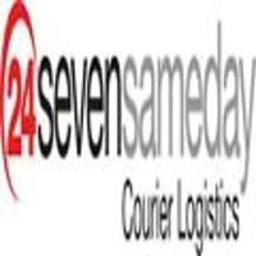

In [152]:
i

In [148]:
new_train[k], new_test[k]

('Temptations', 'Temptations')

In [136]:
new_test = {} 
for item, key in total_testset.label_dict.items(): 
    new_test[key] = item
    
new_train = {} 
for item, key in total_trainset.label_dict.items(): 
    new_train[key] = item

In [137]:
new_test

{0: 'Scholler',
 1: 'Oreo',
 2: 'Mist',
 3: 'McCafe',
 4: 'Frosted Toast Crunch',
 5: 'KP Nuts',
 6: "Smith's Crisps",
 7: 'Nine West',
 8: 'Butterfinger Bites',
 9: 'Kix',
 10: 'Top',
 11: 'H. J. Heinz',
 12: 'Akubra',
 13: 'Marmara',
 14: 'Standard',
 15: 'Karma',
 16: 'Tropicana',
 17: 'Gateway',
 18: 'La Vie',
 19: "Reese's Puffs",
 20: 'Calvin Klein',
 21: 'PG Tips',
 22: 'Cathay',
 23: 'Vittel',
 24: 'Amora',
 25: 'Pertamina',
 26: 'Texas Roadhouse',
 27: 'Rima',
 28: 'Kent',
 29: 'Neutral',
 30: 'saky',
 31: 'Campbells',
 32: 'J. Lancaster & Son',
 33: 'The Real Deal',
 34: 'DC Shoes',
 35: 'Elf',
 36: 'Buffalo Rock Ginger Ale',
 37: 'Mr Greedy',
 38: 'Senator',
 39: 'Choice Hotels',
 40: 'Breath Savers',
 41: 'Domus',
 42: 'Bassett',
 43: 'Liga',
 44: 'Julmust',
 45: 'Vimto',
 46: 'SUNING',
 47: 'Molson Canadian 67',
 48: 'Organic Wild Puffs',
 49: 'Schweppes Tonic',
 50: 'Kern',
 51: "Newman's Own",
 52: 'Life is good',
 53: 'Supra',
 54: 'Crown',
 55: 'Persil',
 56: 'Los Ange

In [138]:
new_train

{0: 'Scholler',
 1: 'Oreo',
 2: 'Mist',
 3: 'McCafe',
 4: 'Frosted Toast Crunch',
 5: 'KP Nuts',
 6: "Smith's Crisps",
 7: 'Nine West',
 8: 'Butterfinger Bites',
 9: 'Kix',
 10: 'Top',
 11: 'H. J. Heinz',
 12: 'Akubra',
 13: 'Marmara',
 14: 'Standard',
 15: 'Karma',
 16: 'Tropicana',
 17: 'Gateway',
 18: 'La Vie',
 19: "Reese's Puffs",
 20: 'Calvin Klein',
 21: 'PG Tips',
 22: 'Cathay',
 23: 'Vittel',
 24: 'Amora',
 25: 'Pertamina',
 26: 'Texas Roadhouse',
 27: 'Rima',
 28: 'Kent',
 29: 'Neutral',
 30: 'saky',
 31: 'Campbells',
 32: 'J. Lancaster & Son',
 33: 'The Real Deal',
 34: 'DC Shoes',
 35: 'Elf',
 36: 'Buffalo Rock Ginger Ale',
 37: 'Mr Greedy',
 38: 'Senator',
 39: 'Choice Hotels',
 40: 'Breath Savers',
 41: 'Domus',
 42: 'Bassett',
 43: 'Liga',
 44: 'Julmust',
 45: 'Vimto',
 46: 'SUNING',
 47: 'Molson Canadian 67',
 48: 'Organic Wild Puffs',
 49: 'Schweppes Tonic',
 50: 'Kern',
 51: "Newman's Own",
 52: 'Life is good',
 53: 'Supra',
 54: 'Crown',
 55: 'Persil',
 56: 'Los Ange